# Unsupervised learning

<p align="center">
  <img src="https://pbs.twimg.com/media/DsCTvc3XQAE7Njb?format=jpg&name=4096x4096" width="75%">
<p>

Unsupervised learning tries to find patterns within the data without pre-assigned labels.
For example, apples and bananas are fruits but, they are clearly different regarding their color and shape.

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['font.size'] = 15
rcParams['figure.figsize'] = (7,7)
plt.style.use('ggplot'); plt.style.use('seaborn-white')
sns.set_style('white')
    
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.datasets import load_iris
data = load_iris()

## Distance and dissimilarity metrics

## k-means clustering

### Lloyd's Algorithm (a.k.a. naive k-means)

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif" width="25%">

0. **Initialization**:
    - Pre-define **k** groups (clusters) of observations.
    - Pre-define **k** centroids sampling randomly from the observations.
1. **Assignment**: Assign every observation to a cluster initializing centroids.
2. **Update**: Calculate the centroid (mean) across observations within the cluster.
3. Go back to 1, until the cluster assignments don't change or we reach a maximum number of iterations.

### Create a function to perform k-means clustering

In [39]:
def kmeans(X, k, metric='euclidean', max_iter=1000):
    """
    Runs naive k-means clustering algorithm.
    
    Parameters
    ----------
    X: np.array; with observations as rows and features as columns.
    k: int; number of clusters.
    metric: str; desired distance metric to use in sklearn.metrics.pairwise_distances().
    max_iter: int; maximum number of iterations allowed.
    
    Returns
    -------
    labels: np.array; cluster labels.
    
    Example
    -------
    from sklearn.datasets import load_iris
    X = load_iris()['data']
    k = 3
    labels = kmeans(X, k)
    print(labels)
    """
    
    # initialization
    ## randomly start centroids
    idx = np.random.choice(np.arange(X.shape[0]), k)
    centroids = X[idx,:]
    ## measure the distances of all observations to the randomly chosen
    d = pairwise_distances(X, centroids, metric=metric)
    ## assign cluster labels to each observation
    labels = np.argmin(d, axis=1)

    # iterate until convergence or reaching 'max_iter'
    for it in range(max_iter):
        # update the centroids
        centroids = np.stack([np.mean(X[labels == label,:], axis=0) for label in np.unique(labels)])

        # measure the distances of all observations to the randomly chosen
        d = pairwise_distances(X, centroids, metric=metric)

        # assign cluster labels to each observation
        labels_old = labels
        labels = np.argmin(d, axis=1)

        # have the cluster labels changed?
        has_converged = all(labels==labels_old)
        if has_converged: break
        
        # notify in case of no convergence
        if it==(max_iter-1): print('WARNING: no convergence.')

    return labels

help(kmeans)

Help on function kmeans in module __main__:

kmeans(X, k, metric='euclidean', max_iter=1000)
    Runs naive k-means clustering algorithm.
    
    Parameters
    ----------
    X: np.array; with observations as rows and features as columns.
    k: int; number of clusters.
    metric: str; desired distance metric to use in sklearn.metrics.pairwise_distances().
    max_iter: int; maximum number of iterations allowed.
    
    Returns
    -------
    labels: np.array; cluster labels.
    
    Example
    -------
    from sklearn.datasets import load_iris
    X = load_iris()['data']
    k = 3
    labels = kmeans(X, k)
    print(labels)



### visualize how the algorithm behaves on iris data

(150, 4)


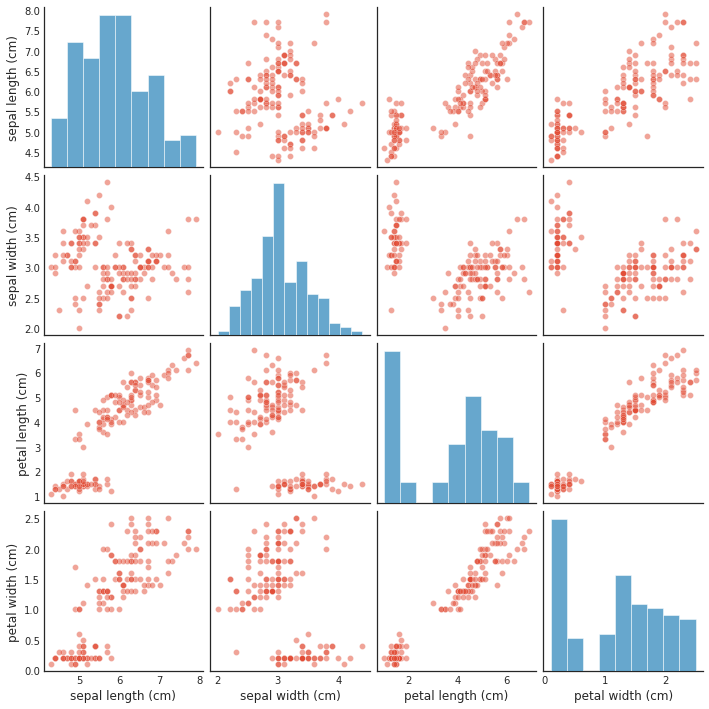

In [166]:
# sample data
X = pd.DataFrame(data['data'], columns=data['feature_names'])
print(X.shape)

sns.pairplot(X, plot_kws={'alpha':0.5})
plt.show()

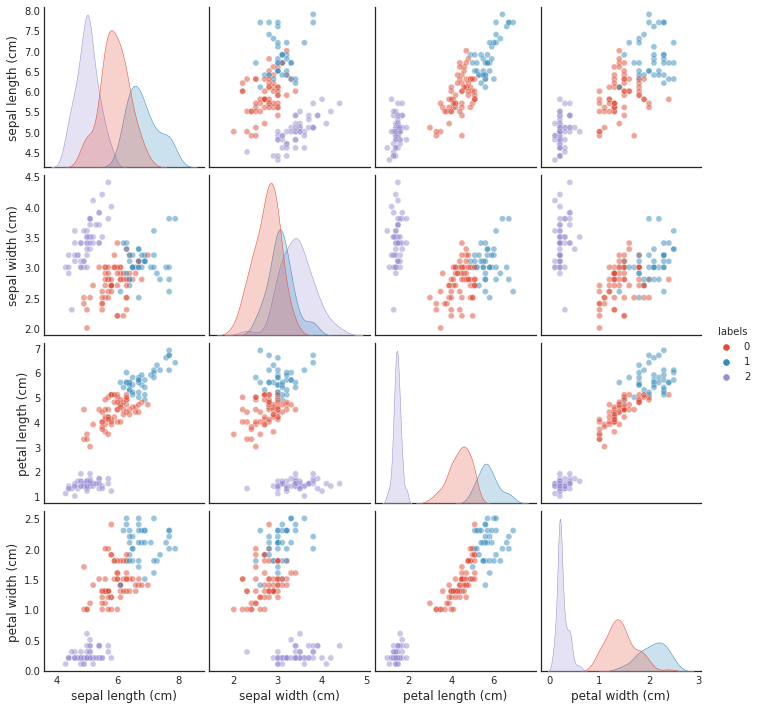

In [167]:
# run our kmeans
X['labels'] = kmeans(X.values, k=3)

# visualize
sns.pairplot(X.astype({'labels':'category'}), hue = 'labels', plot_kws={'alpha':0.5})
plt.show()

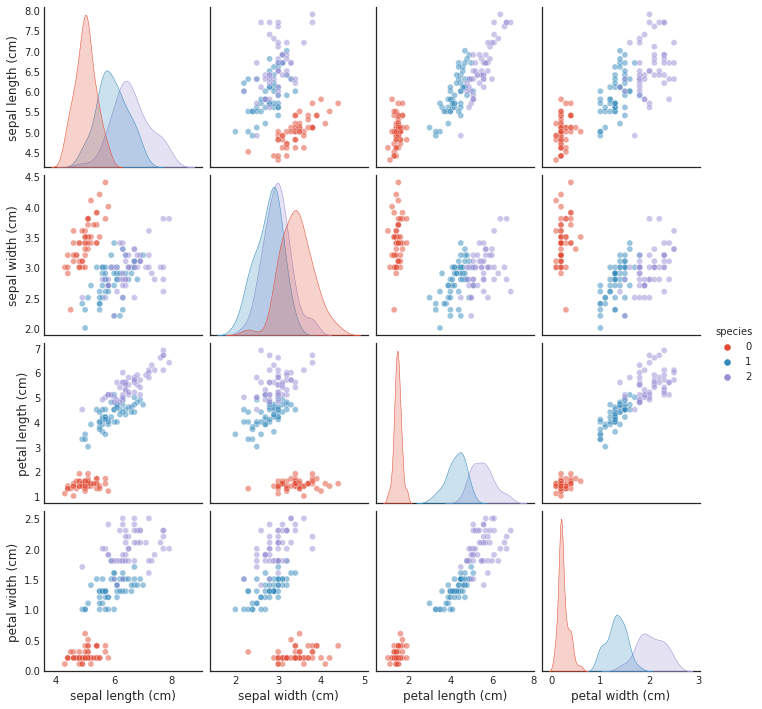

In [168]:
# check with species information
X['species'] = data['target']

sns.pairplot(X.drop(columns='labels').astype({'species':'category'}), hue='species', plot_kws={'alpha':0.5})
plt.show()

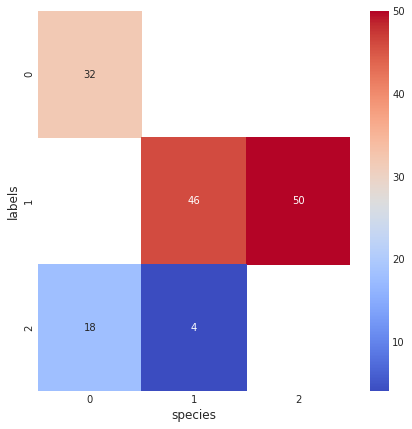

In [161]:
# How good where we? 
df = X.groupby(['species','labels']) \
      .size() \
      .reset_index(name='count') \
      .pivot(index = 'labels', columns = 'species', values = 'count')

g = sns.heatmap(df, cmap='coolwarm', annot=True)
plt.show()

Although in real unsupervised learning problems we don't have ground truth labels (or we don't know which ones they are), in this case we can see that k-means is able to assign the different plants observed to their species quite well using information from their sepal and petals.

## Hierarchical clustering

## Gaussian Mixture Models

## Finding the "key"

### Elbow method

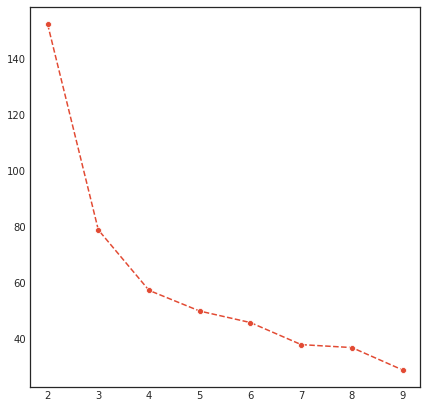

In [162]:
X = data['data']

# run kmeans for different keys
keys = np.arange(2,10)
labels_bykey = {k: kmeans(X, k) for k in keys}

# for every k, measure the average squared error within each cluster
errors = []
for k in keys:
    labels = labels_bykey[k]
    error = 0
    for label in np.unique(labels):
        X_incluster = X[labels==label,:]

        # compute the centroid
        centroid = np.mean(X_incluster, axis=0).reshape(1,-1)

        # compute the within cluster distances to the centroid
        d = pairwise_distances(X_incluster, centroid, metric='euclidean')

        # transform into error
        error += np.sum(d**2)
    
    # save total error sum
    errors.append(error)
    
sns.lineplot(x = keys, y = errors, marker='o', linestyle='dashed')
plt.show()

### Slihouette method
- measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation)
- ranges from $[-1, 1]$
- the higher the better
- scores if a point is placed to the right cluster

**Silhouette Value**
$$
    s(i)= 
\begin{cases}
    \frac{b(i) - a(i)}{max\{a(i),b(i)\}},& \text{if } |C_i| > 1\\
    0,              & \text{if } |C_i| = 1
\end{cases}
$$

Where, $a(i)$ is the within cluster average distance for each data point $i$ in cluster $C_i$,
$$a(i) = \frac{1}{|C_i| - 1} \sum_{j \in C_i, i \neq j} d(i,j)$$

And, $b(i)$ is the minimum distance of each data point $i$ in cluster $C_i$ with the points in cluster $C_j$:
$$b(i) = min_{i \neq j} \frac{1}{|C_j|} \sum_{j \in C_j} d(i,j)$$

In [141]:
def compute_silhouette(X, labels, metric='euclidean'):
    """
    Calculates silhouete value for every observation in X given a set of labels.
    
    Parameters
    ----------
    X
    labels
    metric
    
    Returns
    -------
    silhouette: list; silhouette values.
    
    Example
    -------
    labels = kmeans(X, k=4)
    metric = 'euclidean'

    """
    
    # for every data point (row)
    silhouette = []
    for i in range(X.shape[0]):
        # definitions
        x_i = X[i,:].reshape(1, -1)
        label_i = labels[i]
        C_i = labels == label_i

        # if the cluster size is larger than 1
        clustersize = sum(C_i)
        if clustersize>1:
            # compute within cluster average distance a
            idx_withincluster = [idx for idx in np.where(C_i)[0] if idx != i]
            a_i = (1/(clustersize)) * np.sum( pairwise_distances(X[idx_withincluster,:], x_i, metric=metric) )

            # compute between cluster acerage minimum distance b
            other_labels = [label for label in np.unique(labels) if label != label_i]
            b_ij = []
            for label_j in other_labels:
                idx_othercluster = labels == label_j
                b_ij.append( np.sum( pairwise_distances(X[idx_othercluster,:], x_i, metric=metric) ) )
            b_i = np.min(b_ij)

            # compute silhouette value
            s = (b_i - a_i)/(np.max([a_i, b_i]))

        # else, sihouette is 0
        else: s=0
            
        silhouette.append(s)
        
    return np.array(silhouette)

help(compute_silhouette)

Help on function compute_silhouette in module __main__:

compute_silhouette(X, labels, metric='euclidean')
    Calculates silhouete value for every observation in X given a set of labels.
    
    Parameters
    ----------
    X
    labels
    metric
    
    Returns
    -------
    silhouette: list; silhouette values.
    
    Example
    -------
    labels = kmeans(X, k=4)
    metric = 'euclidean'



In this case, we are scoring how well every data point maps to its own cluster with respect to the others.

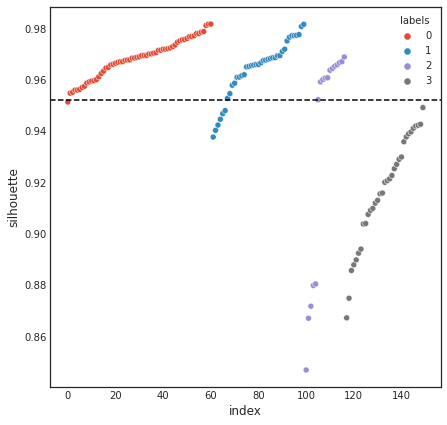

In [177]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
X['labels'] = kmeans(X.values, k=3)
X['silhouette'] = compute_silhouette(X.values, labels)

df = X.sort_values(['labels','silhouette'])\
      .reset_index(drop=True)\
      .reset_index()\
      .astype({'labels':'category'})

sns.scatterplot(x = 'index', y = 'silhouette', hue = 'labels', data = df)
plt.axhline(np.mean(df['silhouette']), linestyle='dashed', color='black')
plt.show()

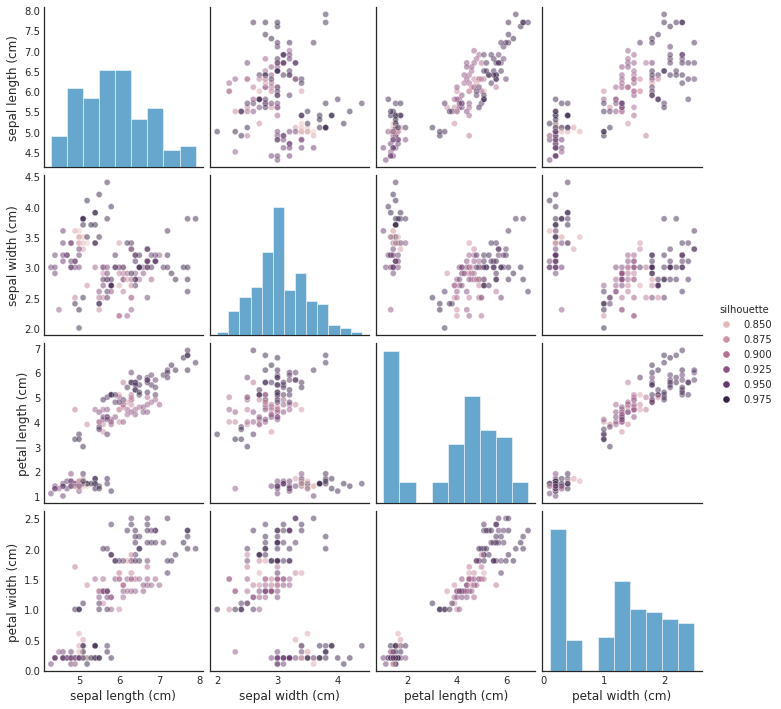

In [173]:
sns.pairplot(X.drop(columns='labels'), plot_kws={'alpha':0.5}, hue='silhouette', diag_kind='hist', diag_kws={'hue':None})
plt.show()

We can choose K using the sihouette score through the elbow method

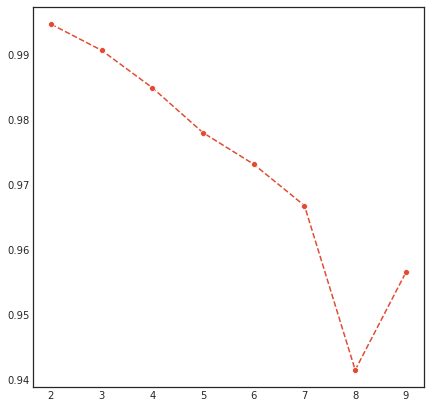

In [176]:
X = data['data']

# run kmeans for different keys
keys = np.arange(2,10)
labels_bykey = {k: kmeans(X, k) for k in keys}

# for every k, measure the average silhouette
errors = []
for k in keys:
    labels = labels_bykey[k]
    error = np.mean(compute_silhouette(X, labels))
    # save total error sum
    errors.append(error)
    
sns.lineplot(x = keys, y = errors, marker='o', linestyle='dashed')
plt.show()